# Lattice3D: developer's guide and tools

In [2]:
%matplotlib inline
#
from LRGSG_package.shared import *
from LRGSG_package.config.utils import *
from LRGSG_package.nx_patches.objects import Lattice3D
#
move_to_rootf()

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


## Developing

### Degree sequence check

In [46]:
expectedDegrees = 6
degree_count = {node: 0 for node in l.G.nodes()}
# Iterate over all edges in the graph
for u, v, data in l.G.edges(data=True):
    # Check if the edge is of the desired type
    degree_count[u] += 1
    degree_count[v] += 1
# degree_count now contains the degree of each node based on type 1 links only
print(np.where(np.array(list(degree_count.values())) != expectedDegrees)[0])

[]


In [ ]:
class LatticeGenerator:
    def __init__(self, dim, pbc=True):
        self.dim = dim
        self.pbc = pbc

    def _wrap_coordinate(self, coord):
        """Wrap coordinates according to PBC and lattice dimensions."""
        return tuple(c % d for c, d in zip(coord, self.dim))

    def _generate_fcc_lattice(self):
        G = nx.Graph()
        
        # Offsets for FCC lattice to include face-centered points
        fcc_offsets = [(0, 0, 0), (0.5, 0.5, 0), (0.5, 0, 0.5), (0, 0.5, 0.5)]

        # Generate all nodes, considering PBC for wrapping
        nodes = set(self._wrap_coordinate((x + ox, y + oy, z + oz))
                    for x, y, z in product(range(self.dim[0]), range(self.dim[1]), range(self.dim[2]))
                    for ox, oy, oz in fcc_offsets)

        G.add_nodes_from(nodes)

        # Pre-calculate wrapped neighbors for each node considering PBC
        node_list = list(G.nodes())
        for nd in node_list:
            for ox, oy, oz in fcc_offsets:
                for dx, dy, dz in [(-0.5, -0.5, 0), (-0.5, 0.5, 0), (0.5, -0.5, 0), (0.5, 0.5, 0),
                                   (-0.5, 0, -0.5), (-0.5, 0, 0.5), (0.5, 0, -0.5), (0.5, 0, 0.5),
                                   (0, -0.5, -0.5), (0, -0.5, 0.5), (0, 0.5, -0.5), (0, 0.5, 0.5)]:
                    # Wrap neighbor coordinates considering PBC
                    neighbor = self._wrap_coordinate((nd[0] + ox + dx, nd[1] + oy + dy, nd[2] + oz + dz))
                    if neighbor in nodes and neighbor != nd:
                        G.add_edge(nd, neighbor)

        return G

# Example usage
dim = (4, 4, 4)  # Specify dimensions of the FCC lattice
lattice_gen = LatticeGenerator(dim)
G = lattice_gen._generate_fcc_lattice()

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

## Tools

### Cluster distribution

In [ ]:
# init
side = 10
pflip = 0.19
nAvg = 100
distDict = Counter()
#
np.random.seed(0)
random.seed(0)

In [ ]:
# run
for _ in range(nAvg):
    l = Lattice3D(side, pflip=pflip, sgpath="test_data/")
    l.flip_random_fract_edges()
    distDict += l.cluster_distribution()
#
basename = f"clusterDistribution_p={pflip:.3g}_na={nAvg}.pkl"
fname = os.path.join(l.lrgsgpath, basename)
with open(fname, 'wb') as f:
    pk.dump(distDict, f)

In [ ]:
# load and prepare
test = pk.load(open(fname, 'rb'))
k,v  = unzip_dict_items(test)
arr = np.repeat(k, v)
x, pdf = powerlaw.pdf(arr)

In [ ]:
# plot
fig, ax = plt.subplots(figsize=(7, 3.5))
#
ax.loglog(x[1:], pdf)
ax.loglog(x[1:], x[1:]**(-2.18))
#
ax.set_xlabel(r"$S$")
ax.set_ylabel(r"$P(S)$")
#
fig.tight_layout()

### Network representation

In [36]:
# init
side = 4
geo = 'sc'
#
pflip = 0.4
theta = np.pi/3
phi = np.pi/6
kwargs = dict(pflip=pflip, theta=theta, phi=phi, with_positions=True, sgpath="test_data/")

In [37]:
# computations
l = Lattice3D(side, geo, **kwargs)
l.flip_random_fract_edges()
l.load_eigV_on_graph(binarize=True)

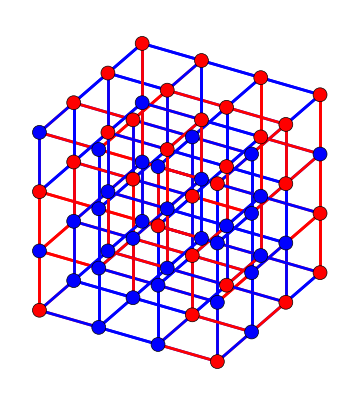

In [38]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
edgeColrs = ['blue' if l.G[u][v]['weight'] > 0 else 'r' 
             for u, v in l.G.edges()]
nx.draw(l.G, ax=ax, pos=l.get_node_pos(), edge_color=edgeColrs, cmap='red_blue', 
        width=2, node_size=100, node_color=l.get_node_attr('eigV0'), 
        linewidths=0.5, edgecolors='k')